
## **Adopter Prediction Challenge**

 ~ Ankita, Ashok, Kaydee, Young
 
 ---

Website XYZ, a music-listening social networking website, follows the “freemium” business model. The website offers basic services for free, and provides a number of additional premium capabilities for a monthly subscription fee. We are interested in predicting which people would be likely to convert from free users to premium subscribers in the next 6 month period, if they are targeted by our promotional campaign.

### Dataset

We have a dataset from the previous marketing campaign which targeted a number of non-subscribers.

Features: 

```
1.   adopter (predictor class)
2.   user_id
3.   age
4.   male
5.   friend_cnt
6.   avg_friend_age
7.   avg_friend_male
8.   friend_country_cnt
9.   subscriber_friend_cnt
10.   songsListened
11.   lovedTracks
12.   posts
13.   playlists
14.   shouts
15.   good_country
16.   tenure
17.   *other delta variables*
```



### Task

The task is to build the best predictive model for the next marketing campaign, i.e., for predicting likely `adopters` (that is, which current non- subscribers are likely to respond to the marketing campaign and sign up for the premium service within 6 months after the campaign).

---

### EDA

Performing some rudimentary EDA

In [0]:
!pip3 install sklearn

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split,  KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from keras.layers.advanced_activations import PReLU

from sklearn.decomposition import PCA

from google.colab import drive

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, classification_report, recall_score, f1_score, accuracy_score, precision_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [0]:
# setting fixed seed value for consistency in results
seed = 7
np.random.seed(seed)

In [3]:
# drive.mount('/content/drive/')

# original dataset
data = pd.read_csv('https://drive.google.com/uc?export=view&id=1wctM0dYDj839zp6sTlFnDgCmFspXhDuW')

# rose_data from the R script
# data = pd.read_csv('https://drive.google.com/uc?export=view&id=14wilOFigXttteZAt5oUHT9fh1m5LhnJj')

data.adopter.value_counts()

0    85142
1     1540
Name: adopter, dtype: int64

# PCA

The neural net is overfitting for either of the classes (regardless of the sample ration). We'll try extracting top x important features to reduce the number of dimensions our net has to deal with.

In [0]:
# # Let's reduce the feature space to 10 Principal Components
# pca = PCA(n_components=2, svd_solver='full')
# pca.fit(data)

# # fetching the principal components
# pca_df = pca.transform(data)
# pca_df

# # using the principal components to fetch feature importances
# # reference - http://benalexkeen.com/principle-component-analysis-in-python/ 
# def fetch_feature_importance(pca_df, components, cols):
  
#   num_columns = len(cols)
  
#   xvector = components[0] * max(pca_df[:,0])
#   yvector = components[1] * max(pca_df[:,1])
  
#   imp_features = { cols[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
#   imp_features = sorted(zip(imp_features.values(), imp_features.keys()), reverse=True)
# #   print ("Features by importance:\n", imp_features)
#   return imp_features

# imp_features = fetch_feature_importance(pca_df, pca.components_, data.columns.values)

# pca_features = []

# for item in imp_features:
#   pca_features.append(item[1])
  
# top_pca_features = pca_features[0:13]

# # fetching top 12 features from the dataset
# X = data[top_pca_features]
# X = X.drop(['user_id'], axis = 1)
# y = data.iloc[:, data.columns == 'adopter']

,adopter
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [0]:
# # splitting original dataset into features and predictor - uncomment if no PCA is needed
# # X = data.iloc[:, data.columns != 'adopter']
# # y = data.iloc[:, data.columns == 'adopter']
# # 
# # splitting the original dataset for cross-validation (0.7 train, 0.3 test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# print ("Original Data:")
# print ("Number of train instances: {}".format(len(X_train)))
# print ("Number of test instances: {}".format(len(X_test)))

Original Data:
Number of train instances: 60677
Number of test instances: 26005


## SMOTE splitting

We'll use SMOTE (Synthetic Minority Oversampling Technique) to create(synthesize) more samples of minority class. The recall score we got earlier might be less as we imputed more than 80% of the data to balance the dataset. 

Before we SMOTE the entire dataset, synthesizing around 58000 new instances of minority will not introduce enough variation in data for the models to learn. 

We decide that we will include only a subset of the majority class instances and synthsize new instances for minority class using SMOTE. That'll (hopefully) avoid our models from overfitting. 

In [4]:
# fetching the indices of minority instances
adopting_indices = np.array(data[data.adopter == 1].index)

# fetching indices of normal instances
non_adopting_indices = data[data.adopter == 0].index

# randomly select 1540 normal instances to create a partitioned balanced dataset
random_non_adopting_indices = np.random.choice(non_adopting_indices,
                                            3540,
                                            replace = False)
random_non_adopting_indices = np.array(random_non_adopting_indices)

# combining both the instance groups (minority and the new random set) 
undersampled_indices = np.concatenate([adopting_indices, random_non_adopting_indices])

# creating the undersampled dataset
undersampled_data = data.iloc[undersampled_indices, :]

# shufling the new dataset
undersampled_data = shuffle(undersampled_data, random_state = seed)

# storing the features(X) and predictor class(y)
X_undersample = undersampled_data.iloc[:, undersampled_data.columns != 'adopter']
y_undersample = undersampled_data.iloc[:, undersampled_data.columns == 'adopter']

print("Number of minority instances: {}\nNumber of normal instances: {} \nTotal: {}".format(len(undersampled_data[undersampled_data.adopter == 1]), 
                                                                                           len(undersampled_data[undersampled_data.adopter == 0]),
                                                                                           len(undersampled_data)))

Number of minority instances: 1540
Number of normal instances: 3540 
Total: 5080


# PCA

The neural net is overfitting for either of the classes (regardless of the sample ration). We'll try extracting top x important features to reduce the number of dimensions our net has to deal with.

In [0]:
# Let's reduce the feature space to 10 Principal Components
pca = PCA(n_components=2, svd_solver='full')
pca.fit(undersampled_data)

# fetching the principal components
pca_df = pca.transform(undersampled_data)
pca_df

# using the principal components to fetch feature importances
# reference - http://benalexkeen.com/principle-component-analysis-in-python/ 
def fetch_feature_importance(pca_df, components, cols):
  
  num_columns = len(cols)
  
  xvector = components[0] * max(pca_df[:,0])
  yvector = components[1] * max(pca_df[:,1])
  
  imp_features = { cols[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
  imp_features = sorted(zip(imp_features.values(), imp_features.keys()), reverse=True)
#   print ("Features by importance:\n", imp_features)
  return imp_features

imp_features = fetch_feature_importance(pca_df, pca.components_, data.columns.values)

pca_features = []

for item in imp_features:
  pca_features.append(item[1])
  
top_pca_features = pca_features[0:13]

# fetching top 12 features from the dataset
X = undersampled_data[top_pca_features]
X = X.drop(['user_id'], axis = 1)
y = undersampled_data.iloc[:, undersampled_data.columns == 'adopter']

In [6]:
# # splitting original dataset into features and predictor
# X = undersampled_data.iloc[:, data.columns != 'adopter']
# y = undersampled_data.iloc[:, data.columns == 'adopter']

# splitting the original dataset for cross-validation (0.7 train, 0.3 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print ("Undersampled Data:")
print ("Number of train instances: {}".format(len(X_train)))
print ("Number of test instances: {}".format(len(X_test)))

Undersampled Data:
Number of train instances: 3556
Number of test instances: 1524


In [7]:
sm = SMOTE(random_state = 12, ratio = None)
X_train_smoted_np, y_train_smoted_np = sm.fit_sample(X_train, y_train)
# X_train_smoted, y_train_smoted = sm.fit_sample(X_train, y_train.values.ravel())
print(type(X_train_smoted_np))

<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
# # checking the lengths of new training set

print ("Number of SMOTEd instances: {}".format(len(X_train_smoted_np)))

X_train.head()
y_train_smoted_non_adopters = y_train_smoted_np[y_train_smoted_np == 1]
y_train_smoted_adopters = y_train_smoted_np[y_train_smoted_np == 0]

print ("Number of SMOTEd non-adopters (adopter = 0): {}".format(len(y_train_smoted_non_adopters)))
print ("Number of SMOTEd adopters (adopter = 1): {}".format(len(y_train_smoted_adopters)))

X_train = X_train_smoted_np
y_train = y_train_smoted_np

Number of SMOTEd instances: 5014
Number of SMOTEd non-adopters (adopter = 0): 2507
Number of SMOTEd adopters (adopter = 1): 2507


We now have around 2792 instances each of both the classes, which is better than simple undersampling and having only 3080 instances in all.



For now we'll import smoted data from our R scripts since the above is taking time.

## Building a shallow NN

In [0]:
# temp function to plot confusion matrix

def plot_conf_matrix(cm, 
                     classes,
                     normalize=False,
                     title='Confusion matrix',
                     cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
# temp function to plot training accuracy and loss

def plot_acc_loss(class_hist):
  plt.subplot(211)
  plt.title('Loss')
  plt.plot(class_hist.history['loss'], label='train')
  plt.plot(class_hist.history['val_loss'], label='test')
  plt.legend()
  
  plt.subplot(212)
  plt.title('Accuracy')
  plt.plot(class_hist.history['acc'], label='train')
  plt.plot(class_hist.history['val_acc'], label='test')
  plt.legend()
  plt.show()

In [0]:
# Baseline NN with single hidden layer (num of neurons = num of features)
# num_neurons = undersampled_data.shape[1] - 1

def baseline_nn():
  num_neurons = 12
  model = Sequential()	
  
  # 100 hidden neurons + input neurons 
#   model.add(Dropout(0.2, input_shape = (undersampled_data.shape[1] - 1, )))

  model.add(Dense(num_neurons, input_shape=(X.shape[1],)))
  model.add(Dropout(0.1))#    input dropout
  model.add(PReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(360))
  model.add(PReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(420))
  model.add(PReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(1))
  model.add(Activation('softmax'))
  #opt=SGD(momentum=0.9)
  model.compile(loss='binary_crossentropy', optimizer="sgd")
  
#   model.add(Dense(num_neurons,        
#                   input_dim = X.shape[1],
#                   kernel_initializer = 'normal', 
#                   activation = 'tanh',
#                   activity_regularizer=l1(0.01)))
  
#   model.add(Dropout(0.2))
  
#   model.add(Dense(10, 
#                   kernel_initializer = 'normal', 
#                   activation = 'tanh',
#                   activity_regularizer=l1(0.01)))
  
#   model.add(Dropout(0.2))
  
#   model.add(Dense(1, 
#                   kernel_initializer = 'normal', 
#                   activation='sigmoid'))	
  
#   model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  
  return model

In [18]:
X.shape[1]-1

11

Train on 3359 samples, validate on 1655 samples
Epoch 1/100
3359/3359 [==============================] - 2s 642us/step - loss: 11.2674 - val_loss: 1.2812
Epoch 2/100
3359/3359 [==============================] - 0s 97us/step - loss: 11.2674 - val_loss: 1.2812
Epoch 3/100
3359/3359 [==============================] - 0s 101us/step - loss: 11.2674 - val_loss: 1.2812
Epoch 4/100
3359/3359 [==============================] - 0s 99us/step - loss: 11.2674 - val_loss: 1.2812
Epoch 5/100
3359/3359 [==============================] - 0s 98us/step - loss: 11.2674 - val_loss: 1.2812
Epoch 6/100
3359/3359 [==============================] - 0s 99us/step - loss: 11.2674 - val_loss: 1.2812
Epoch 7/100
3359/3359 [==============================] - 0s 101us/step - loss: 11.2674 - val_loss: 1.2812
Epoch 8/100
3359/3359 [==============================] - 0s 100us/step - loss: 11.2674 - val_loss: 1.2812
Epoch 9/100
3359/3359 [==============================] - 0s 100us/step - loss: 11.2674 - val_loss: 1.2812
Ep

KeyError: ignored

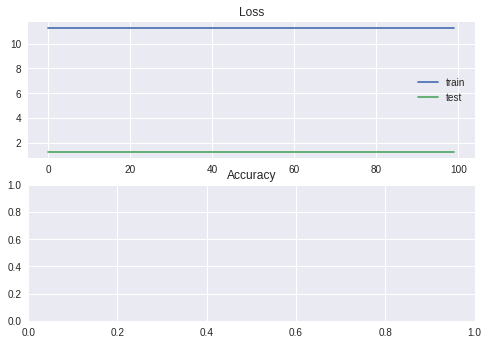

In [35]:
# estimator = KerasClassifier(build_fn = baseline_nn, 
#                             epochs=10, 
#                             batch_size = 5, 
#                             verbose=1)

classifier = baseline_nn()

#class_weights = {0: 1, 1: 10}

classifier_history = classifier.fit(X_train, 
                                    y_train, 
                                    validation_split=0.33, 
                                    batch_size = 256, 
                                    epochs = 100)

# plt.plot(classifier_history.history['acc'])
plot_acc_loss(classifier_history)

In [36]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_20 (Dropout)         (None, 12)                0         
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 12)                12        
_________________________________________________________________
batch_normalization_4 (Batch (None, 12)                48        
_________________________________________________________________
dropout_21 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 360)               4680      
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 360)               360       
__________

In [37]:
y_pred = classifier.predict_classes(X_test)
# y_pred = (y_pred > 0.5)
y_pred
# cm = confusion_matrix(y_test, y_pred)
# plot_conf_matrix(cm, [1,0])

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1033
           1       0.32      1.00      0.49       491

   micro avg       0.32      0.32      0.32      1524
   macro avg       0.16      0.50      0.24      1524
weighted avg       0.10      0.32      0.16      1524

[[   0 1033]
 [   0  491]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
#  y_test.shape[0]
y_pred

In [0]:
# fetching metrics
recall_val = recall_score(y_test, y_pred)
f1_val = f1_score(y_test, y_pred)
acc_val = accuracy_score(y_test, y_pred)
precision_val = precision_score(y_test, y_pred)

print('Accuracy: %f' % acc_val)
print('Precision: %f' % precision_val)
print('Recall: %f' % recall_val)
print('F1 score: %f' % f1_val)

In [0]:
# unseen_data = pd.read_csv('https://drive.google.com/uc?export=view&id=1yVPwqGQC2gkhF2bcbue9j3184ryAJRtG')
# y_pred = classifier.predict_classes(unseen_data)

# np.savetxt("predictions.csv", y_pred , delimiter=",")
# from google.colab import files
# files.download('predictions.csv')